## <a id='1'>1. Import Libraries</a>

In [19]:
!pip install selenium
!pip install tweepy

In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To mock web-browser and scrap tweets
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is alr

In [21]:
class SeleniumClient(object):
    def __init__(self):
        #Initialization method. 
        self.chrome_options = webdriver.ChromeOptions()
        self.chrome_options.add_argument('--headless')
        self.chrome_options.add_argument('--no-sandbox')
        self.chrome_options.add_argument('--disable-setuid-sandbox')

        # you need to provide the path of chromdriver in your system
        self.browser = webdriver.Chrome('D:/chromedriver_win32/chromedriver', options=self.chrome_options)

        self.base_url = 'https://twitter.com/search?q='

    def get_tweets(self, query):
        #Function to fetch tweets. 
        try: 
            self.browser.get(self.base_url+query)
            time.sleep(2)

            body = self.browser.find_element_by_tag_name('body')

            for _ in range(3000):
                body.send_keys(Keys.PAGE_DOWN)
                time.sleep(0.3)

            timeline = self.browser.find_element_by_id('timeline')
            tweet_nodes = timeline.find_elements_by_css_selector('.tweet-text')

            return pd.DataFrame({'tweets': [tweet_node.text for tweet_node in tweet_nodes]})

        except:
            print("Selenium - An error occured while fetching tweets.")

In [22]:
# keys and tokens from the Twitter Dev Console
consumer_key = 'Sec3MvclRIx2RVlgu9l0SJX6D'
consumer_secret = 'ayoPNWtBm7fWpMBoK6EwRmegu3SW8Rw9mzJkottkv97quPe941'
access_token = '736550752760406018-so5CPJrEbJKb3c3Pq8va3VFr0yk4S0E'
access_token_secret = 'Cgr8tz0h6FTU7kxAjDzpHnjffNTHxWsBytXnu4Ihd1TFb'

In [23]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [24]:
# selenium_client = SeleniumClient()

# # calling function to get tweets
# tweets_df = selenium_client.get_tweets('AI and Deep learning')
# print(f'tweets_df Shape - {tweets_df.shape}')
# tweets_df.head(10)

#### <a id='2Ab'>b. Using 'tweepy'</a>

In [25]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets('Disney Plus', maxTweets=7000)
print(f'tweets_df Shape - {tweets_df.shape}')




Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 296 tweets
Downloaded 396 tweets
Downloaded 495 tweets
Downloaded 595 tweets
Downloaded 695 tweets
Downloaded 795 tweets
Downloaded 895 tweets
Downloaded 995 tweets
Downloaded 1095 tweets
Downloaded 1195 tweets
Downloaded 1295 tweets
Downloaded 1395 tweets
Downloaded 1495 tweets
Downloaded 1595 tweets
Downloaded 1695 tweets
Downloaded 1795 tweets
Downloaded 1895 tweets
Downloaded 1995 tweets
Downloaded 2095 tweets
Downloaded 2195 tweets
Downloaded 2295 tweets
Downloaded 2395 tweets
Downloaded 2495 tweets
Downloaded 2595 tweets
Downloaded 2695 tweets
Downloaded 2795 tweets
Downloaded 2895 tweets
Downloaded 2995 tweets
Downloaded 3095 tweets
Downloaded 3195 tweets
Downloaded 3295 tweets
Downloaded 3395 tweets
Downloaded 3495 tweets
Downloaded 3595 tweets
Downloaded 3695 tweets
Downloaded 3794 tweets
Downloaded 3894 tweets
Downloaded 3994 tweets
Downloaded 4094 tweets
Downloaded 4194 tweets
Downloaded 4294 tweets
Downloaded 4394 tweet

,tweets
0,RT @DisneylandParis: Les Disney nuiMOs sont ar...
1,@kayabaudelaire its a good show its on disney ...
2,RT @RemiPrieur: 🎁 CONCOURS 🎁 Voici un mois que...
3,🏷️lf looking for affordable cheap mura premium...
4,"Now ""streaming"" on Disney Plus. https://t.co/D..."
5,🏷️lf looking for affordable cheap mura premium...
6,🏷️lf looking for affordable cheap mura premium...
7,🏷️lf looking for affordable cheap mura premium...
8,RT @loveyourapprem: 💫 JUAL APLIKASI PREMIUM 💫\...
9,RT @kerembrsnfans: Diario Trome hakkında kısa ...


In [64]:
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets,key_phrases
0,RT @DisneylandParis: Les Disney nuiMOs sont ar...,pos,Les Disney nuiMOs sont arrivés à Disneyland Pa...,Les Disney nuiMOs sont arrivs Disneyland Paris...,[les disney nuimos sont arrivés à disneyland p...
1,@kayabaudelaire its a good show its on disney ...,pos,@kayabaudelaire its a good show its on disney ...,kayabaudelaire good show disney plus,[good show]
2,RT @RemiPrieur: 🎁 CONCOURS 🎁 Voici un mois que...,pos,🎁 CONCOUS 🎁 Voici un mois que @DisneylandParis...,CONCOUS Voici un mois que DisneylandParis rouv...,"[🎁 concous 🎁 voici un mois que, pour fêter ça ..."
3,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...,[affordable cheap mura premium accounts spotif...
4,"Now ""streaming"" on Disney Plus. https://t.co/D...",pos,"Now ""streaming"" on Disney Plus.",Now streaming Disney Plus,[disney plus]
5,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...,[affordable cheap mura premium accounts spotif...
6,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...,[affordable cheap mura premium accounts spotif...
7,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...,[affordable cheap mura premium accounts spotif...
8,RT @loveyourapprem: 💫 JUAL APLIKASI PREMIUM 💫\...,pos,💫 JUAL APLIKASI PEMIUM 💫 ✅Aman &amp; Trusted ✅...,JUAL APLIKASI PEMIUM Aman amp Trusted LEGAL Be...,"[💫 jual aplikasi pemium 💫 ✅aman, trusted ✅100%..."
9,RT @kerembrsnfans: Diario Trome hakkında kısa ...,pos,Diario Trome hakkında kısa bilgi ektedir. Düny...,Diario Trome hakknda ksa bilgi ektedir Dnyann ...,"[diario trome hakkında kısa bilgi ektedir, dün..."


In [70]:
twitter_df = pd.DataFrame(tweets_df)
twitter_df.to_csv('TwitterData.csv')

### <a id='2B'>B. Fetch sentiments</a>
To proceed further, we need to know the sentiment type of every tweet, that can be done using two ways: <br/>
    __a. Using NLTK's SentimentIntensityAnalyzer (We'll refer as SIA)<br/>__
    __b. Using TextBlob<br/>__

In [27]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

#### <a id='2Ba'>a. Using NLTK's SentimentIntensityAnalyzer</a>

In [28]:
sentiments_using_SIA = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,tweets
pos,3325
neg,528


#### <a id='2Bb'>b. Using TextBlob</a>

In [29]:
sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,3525
neg,328


TextBlob gives us more negative sentiments than SIA, so we will prefer textblob, since classfication seems better.

In [30]:
tweets_df['sentiment'] = sentiments_using_textblob
tweets_df.head()

,tweets,sentiment
0,RT @DisneylandParis: Les Disney nuiMOs sont ar...,pos
1,@kayabaudelaire its a good show its on disney ...,pos
2,RT @RemiPrieur: 🎁 CONCOURS 🎁 Voici un mois que...,pos
3,🏷️lf looking for affordable cheap mura premium...,pos
4,"Now ""streaming"" on Disney Plus. https://t.co/D...",pos


## <a id='3'>3. Text Pre-processing</a> 
### <a id='3A'>A. Pre-processing 'Key Words'</a>
#### <a id='3Aa'>a. Removing '@names'</a>
Here we can see that at many places we have '@names', which is of no use, since it don't have any meaning, So needs to be removed.

In [31]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [32]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
tweets_df.head(10)

,tweets,sentiment,tidy_tweets
0,RT @DisneylandParis: Les Disney nuiMOs sont ar...,pos,Les Disney nuiMOs sont arrivés à Disneyland P...
1,@kayabaudelaire its a good show its on disney ...,pos,@kayabaudelaire its a good show its on disney ...
2,RT @RemiPrieur: 🎁 CONCOURS 🎁 Voici un mois que...,pos,🎁 CONCOUS 🎁 Voici un mois que @DisneylandPari...
3,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...
4,"Now ""streaming"" on Disney Plus. https://t.co/D...",pos,"Now ""streaming"" on Disney Plus. https://t.co/D..."
5,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...
6,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...
7,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...
8,RT @loveyourapprem: 💫 JUAL APLIKASI PREMIUM 💫\...,pos,💫 JUAL APLIKASI PEMIUM 💫\n\n✅Aman &amp; Trust...
9,RT @kerembrsnfans: Diario Trome hakkında kısa ...,pos,Diario Trome hakkında kısa bilgi ektedir. \n\...


Seems good, now we don't have '@name' values

#### <a id='3Ab'>b. Removing links (http | https)</a>

In [33]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment,tidy_tweets
0,RT @DisneylandParis: Les Disney nuiMOs sont ar...,pos,Les Disney nuiMOs sont arrivés à Disneyland Pa...
1,@kayabaudelaire its a good show its on disney ...,pos,@kayabaudelaire its a good show its on disney ...
2,RT @RemiPrieur: 🎁 CONCOURS 🎁 Voici un mois que...,pos,🎁 CONCOUS 🎁 Voici un mois que @DisneylandParis...
3,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...
4,"Now ""streaming"" on Disney Plus. https://t.co/D...",pos,"Now ""streaming"" on Disney Plus."
5,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...
6,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...
7,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...
8,RT @loveyourapprem: 💫 JUAL APLIKASI PREMIUM 💫\...,pos,💫 JUAL APLIKASI PEMIUM 💫 ✅Aman &amp; Trusted ✅...
9,RT @kerembrsnfans: Diario Trome hakkında kısa ...,pos,Diario Trome hakkında kısa bilgi ektedir. Düny...


#### <a id='3Ac'>c. Removing tweets with empty text</a>

In [34]:
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @DisneylandParis: Les Disney nuiMOs sont ar...,pos,Les Disney nuiMOs sont arrivés à Disneyland Pa...
1,@kayabaudelaire its a good show its on disney ...,pos,@kayabaudelaire its a good show its on disney ...
2,RT @RemiPrieur: 🎁 CONCOURS 🎁 Voici un mois que...,pos,🎁 CONCOUS 🎁 Voici un mois que @DisneylandParis...
3,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...
4,"Now ""streaming"" on Disney Plus. https://t.co/D...",pos,"Now ""streaming"" on Disney Plus."


#### <a id='3Ad'>d. Dropping duplicate rows</a>

In [35]:
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @DisneylandParis: Les Disney nuiMOs sont ar...,pos,Les Disney nuiMOs sont arrivés à Disneyland Pa...
1,@kayabaudelaire its a good show its on disney ...,pos,@kayabaudelaire its a good show its on disney ...
2,RT @RemiPrieur: 🎁 CONCOURS 🎁 Voici un mois que...,pos,🎁 CONCOUS 🎁 Voici un mois que @DisneylandParis...
3,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...
4,"Now ""streaming"" on Disney Plus. https://t.co/D...",pos,"Now ""streaming"" on Disney Plus."


#### <a id='3Ae'>e. Resetting index</a>
It seems that our index needs to be reset, since after removal of some rows, some index values are missing, which may cause problem in future operations.

In [36]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @DisneylandParis: Les Disney nuiMOs sont ar...,pos,Les Disney nuiMOs sont arrivés à Disneyland Pa...
1,@kayabaudelaire its a good show its on disney ...,pos,@kayabaudelaire its a good show its on disney ...
2,RT @RemiPrieur: 🎁 CONCOURS 🎁 Voici un mois que...,pos,🎁 CONCOUS 🎁 Voici un mois que @DisneylandParis...
3,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...
4,"Now ""streaming"" on Disney Plus. https://t.co/D...",pos,"Now ""streaming"" on Disney Plus."


#### <a id='3Af'>f. Removing Punctuations, Numbers and Special characters</a>



In [37]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

#### <a id='3Ag'>g. Removing Stop words</a>
With the same reason we mentioned above, we won't perform this on 'tidy_tweets' column, because it needs to be used for __key_phrases__ sentiment analysis.

In [39]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['absolute_tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,RT @DisneylandParis: Les Disney nuiMOs sont ar...,pos,Les Disney nuiMOs sont arrivés à Disneyland Pa...,Les Disney nuiMOs sont arrivs Disneyland Paris...
1,@kayabaudelaire its a good show its on disney ...,pos,@kayabaudelaire its a good show its on disney ...,kayabaudelaire good show disney plus
2,RT @RemiPrieur: 🎁 CONCOURS 🎁 Voici un mois que...,pos,🎁 CONCOUS 🎁 Voici un mois que @DisneylandParis...,CONCOUS Voici un mois que DisneylandParis rouv...
3,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...
4,"Now ""streaming"" on Disney Plus. https://t.co/D...",pos,"Now ""streaming"" on Disney Plus.",Now streaming Disney Plus
5,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...
6,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...
7,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...
8,RT @loveyourapprem: 💫 JUAL APLIKASI PREMIUM 💫\...,pos,💫 JUAL APLIKASI PEMIUM 💫 ✅Aman &amp; Trusted ✅...,JUAL APLIKASI PEMIUM Aman amp Trusted LEGAL Be...
9,RT @kerembrsnfans: Diario Trome hakkında kısa ...,pos,Diario Trome hakkında kısa bilgi ektedir. Düny...,Diario Trome hakknda ksa bilgi ektedir Dnyann ...


#### <a id='3Ah'>h. Tokenize *'absolute_tidy_tweets'*</a>  

In [40]:
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Les, Disney, nuiMOs, sont, arrivs, Disneyland...
1           [kayabaudelaire, good, show, disney, plus]
2    [CONCOUS, Voici, un, mois, que, DisneylandPari...
3    [lf, looking, affordable, cheap, mura, premium...
4                       [Now, streaming, Disney, Plus]
Name: absolute_tidy_tweets, dtype: object

#### <a id='3Ai'>i. Converting words to Lemma</a>

In [41]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [Les, Disney, nuiMOs, sont, arrivs, Disneyland...
1           [kayabaudelaire, good, show, disney, plus]
2    [CONCOUS, Voici, un, mois, que, DisneylandPari...
3    [lf, looking, affordable, cheap, mura, premium...
4                       [Now, streaming, Disney, Plus]
Name: absolute_tidy_tweets, dtype: object

#### <a id='3Aj'>j. Joining all tokens into sentences</a>

In [42]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,RT @DisneylandParis: Les Disney nuiMOs sont ar...,pos,Les Disney nuiMOs sont arrivés à Disneyland Pa...,Les Disney nuiMOs sont arrivs Disneyland Paris...
1,@kayabaudelaire its a good show its on disney ...,pos,@kayabaudelaire its a good show its on disney ...,kayabaudelaire good show disney plus
2,RT @RemiPrieur: 🎁 CONCOURS 🎁 Voici un mois que...,pos,🎁 CONCOUS 🎁 Voici un mois que @DisneylandParis...,CONCOUS Voici un mois que DisneylandParis rouv...
3,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...
4,"Now ""streaming"" on Disney Plus. https://t.co/D...",pos,"Now ""streaming"" on Disney Plus.",Now streaming Disney Plus
5,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...
6,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...
7,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...
8,RT @loveyourapprem: 💫 JUAL APLIKASI PREMIUM 💫\...,pos,💫 JUAL APLIKASI PEMIUM 💫 ✅Aman &amp; Trusted ✅...,JUAL APLIKASI PEMIUM Aman amp Trusted LEGAL Be...
9,RT @kerembrsnfans: Diario Trome hakkında kısa ...,pos,Diario Trome hakkında kısa bilgi ektedir. Düny...,Diario Trome hakknda ksa bilgi ektedir Dnyann ...


### <a id='3B'>B. Pre-processing 'Key Phrases'</a> 

#### <a id='3Ba'>a. Helper class, will help in preprocessing phrase terms</a>

In [43]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

#### <a id='3Bb'>b. Grammatical rule to identify phrases</a>

In [44]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

#### <a id='3Bc'>c. New feature called 'key_phrases', will contain phrases for corresponding tweet</a>

In [45]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows(): 
    toks = nltk.regexp_tokenize(row.tidy_tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['le disney nuimos sont arrivés  à d isneyland paris  😍 m ettez-les',
  'scène selon votre humeur',
  'partagez vos',
  'bell'],
 ['good show', 'disney'],
 ['🎁 co ncous  voici mois que disneylandparis',
  'rouvert',
  'porte',
  'pour fêter vous propose',
  'remporter mini'],
 ['affordable cheap mura premium account spotify viu canva pro quillbott lightroom lightroom presets'],
 ['disney plus'],
 ['affordable cheap mura premium account spotify viu canva pro quillbott lightroom lightroom presets'],
 ['affordable cheap mura premium account spotify viu canva pro quillbott lightroom lightroom presets'],
 ['affordable cheap mura premium account spotify viu canva pro quillbott lightroom lightroom presets'],
 ['💫 ju  apl ikasi pemium 💫 ✅a man amp',
  '% le gal  bergaransi atusan testi',
  'bio',
  'tag'],
 ['diario trome hakkında kısa bilgi ektedir',
  'dünyanın',
  'çok okunan',
  'i̇spanyolca',
  'peru gazetesi diario trome',
  'kerem bürs']]

In obtained key phrases, we can see words like 'year', 'talk', 'appl', 'compan' etc. are present which should never be considered as key phrases. There is one other simple way to extract key phrases, by using TextBlob (ConllExtractor).

In [46]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets_df.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.tidy_tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['les disney nuimos sont arrivés à disneyland paris',
  'scène selon votre humeur et partagez vos'],
 ['good show'],
 ['🎁 concous 🎁 voici un mois que',
  'pour fêter ça je vous',
  'de remporter ce mini c…'],
 ['affordable cheap mura premium accounts spotify viu canva pro quillbott lightroom lightroom presets…'],
 ['disney plus'],
 ['affordable cheap mura premium accounts spotify viu canva pro quillbott lightroom lightroom presets…'],
 ['affordable cheap mura premium accounts spotify viu canva pro quillbott lightroom lightroom presets…'],
 ['affordable cheap mura premium accounts spotify viu canva pro quillbott lightroom lightroom presets…'],
 ['💫 jual aplikasi pemium 💫 ✅aman',
  'trusted ✅100% legal ✅ bergaransi ✅ atusan testi',
  'bio ✅ wa tag',
  'apk premium legal…'],
 ['diario trome hakkında kısa bilgi ektedir',
  'dünyanın',
  'çok okunan',
  'i̇spanyolca',
  'peru gazetesi diario trome',
  'kerem bürs…']]

These key phrases seems better, let's consider these key phrase only.

In [47]:
tweets_df['key_phrases'] = textblob_key_phrases
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets,key_phrases
0,RT @DisneylandParis: Les Disney nuiMOs sont ar...,pos,Les Disney nuiMOs sont arrivés à Disneyland Pa...,Les Disney nuiMOs sont arrivs Disneyland Paris...,[les disney nuimos sont arrivés à disneyland p...
1,@kayabaudelaire its a good show its on disney ...,pos,@kayabaudelaire its a good show its on disney ...,kayabaudelaire good show disney plus,[good show]
2,RT @RemiPrieur: 🎁 CONCOURS 🎁 Voici un mois que...,pos,🎁 CONCOUS 🎁 Voici un mois que @DisneylandParis...,CONCOUS Voici un mois que DisneylandParis rouv...,"[🎁 concous 🎁 voici un mois que, pour fêter ça ..."
3,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...,[affordable cheap mura premium accounts spotif...
4,"Now ""streaming"" on Disney Plus. https://t.co/D...",pos,"Now ""streaming"" on Disney Plus.",Now streaming Disney Plus,[disney plus]
5,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...,[affordable cheap mura premium accounts spotif...
6,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...,[affordable cheap mura premium accounts spotif...
7,🏷️lf looking for affordable cheap mura premium...,pos,🏷️lf looking for affordable cheap mura premium...,lf looking affordable cheap mura premium accou...,[affordable cheap mura premium accounts spotif...
8,RT @loveyourapprem: 💫 JUAL APLIKASI PREMIUM 💫\...,pos,💫 JUAL APLIKASI PEMIUM 💫 ✅Aman &amp; Trusted ✅...,JUAL APLIKASI PEMIUM Aman amp Trusted LEGAL Be...,"[💫 jual aplikasi pemium 💫 ✅aman, trusted ✅100%..."
9,RT @kerembrsnfans: Diario Trome hakkında kısa ...,pos,Diario Trome hakkında kısa bilgi ektedir. Düny...,Diario Trome hakknda ksa bilgi ektedir Dnyann ...,"[diario trome hakkında kısa bilgi ektedir, dün..."


## <a id='4'>4. Story Generation and Visualization</a>

#### <a id='4A'>A. Most common words in positive tweets</a>
Answer can be best found using WordCloud

In [48]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

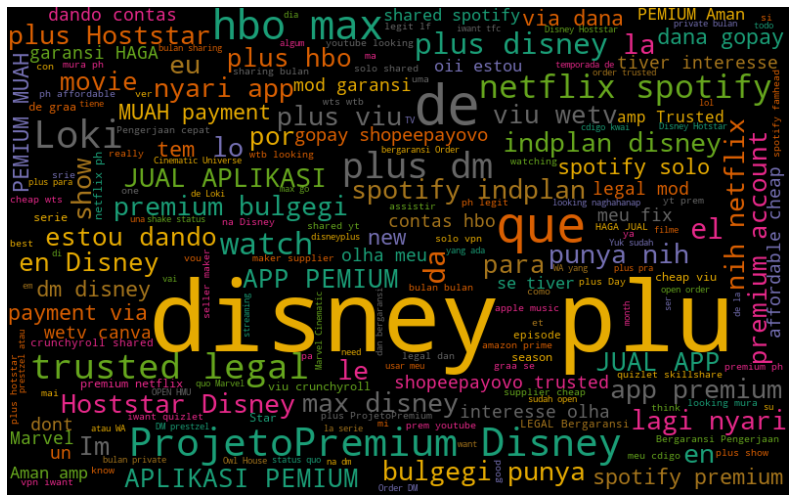

In [49]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'pos']])
generate_wordcloud(all_words)

#### <a id='4B'>B. Most common words in negative tweets</a>

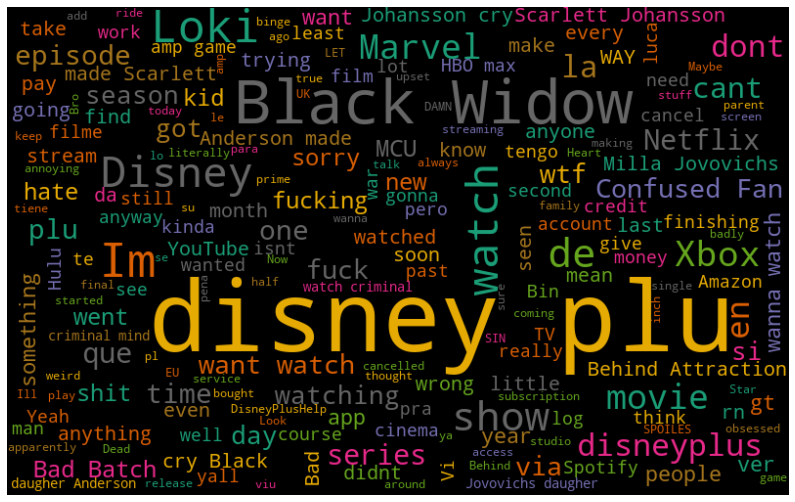

In [50]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'neg']])
generate_wordcloud(all_words)

#### <a id='4C'>C. Most commonly used Hashtags</a>

In [51]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [52]:
hashtags = hashtag_extract(tweets_df['tidy_tweets'])
hashtags = sum(hashtags, [])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3627 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3634 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3604 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 3627 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 3634 missing from current font.
  font.set_text(s, 

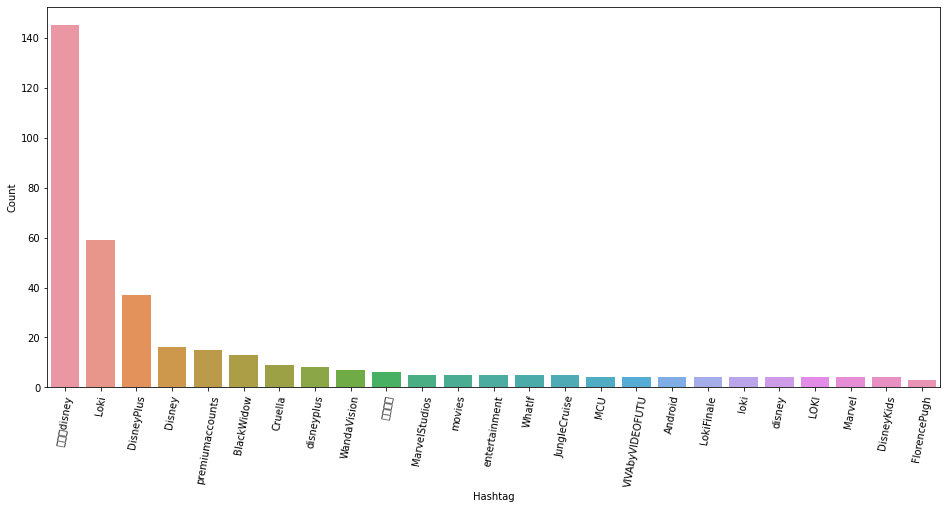

In [53]:
generate_hashtag_freqdist(hashtags)

In [54]:
# For sake of consistency, we are going to discard the records which contains no phrases i.e where tweets_df['key_phrases'] contains []
tweets_df2 = tweets_df[tweets_df['key_phrases'].str.len()>0]

## <a id='5'>5. Feature Extraction</a>


### <a id='5A'>A. Feature Extraction for 'Key Words'</a>

In [55]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

### <a id='5B'>B. Feature Extraction for 'Key Phrases'</a>

In [56]:
phrase_sents = tweets_df2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

## <a id='6'>6. Model Building: Sentiment Analysis</a>

#### Map target variables to  {0, 1}

In [57]:
target_variable = tweets_df2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [58]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

In [59]:
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

### <a id='6A'>A. Predictions on 'key words' based features</a>

#### <a id='6Aa'>a. BOW word features</a>

Accuracy Score - 0.8729729729729729


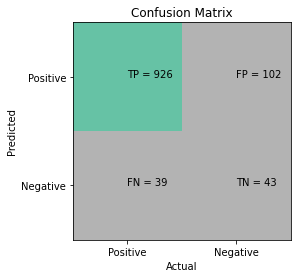

In [60]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

#### <a id='6Ab'>b. TF-IDF word features</a>

Accuracy Score - 0.872072072072072


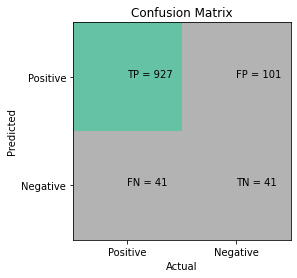

In [61]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

### <a id='6B'>B. Predictions on 'key phrases' based features</a>

#### <a id='6Ba'>a. BOW Phrase features</a>

Accuracy Score - 0.8333333333333334


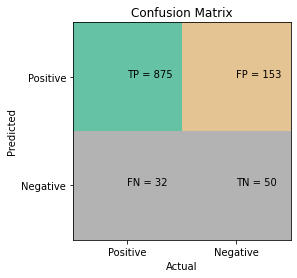

In [62]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

#### <a id='6Bb'>b. TF-IDF Phrase features</a>

Accuracy Score - 0.8306306306306306


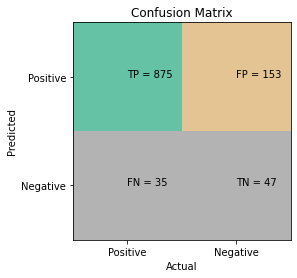

In [63]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

Features extracted from 'key words' helps model in performing better. They have better positive predictions than the later one. However, using 'key-phrase' based features improves the negative predictions.<br/><br/>
__This is it from my side, suggestions are always welcome. Thanks :)__